In [ ]:
%load_ext autoreload
%autoreload 2

### Data setup

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from prod.engine_utils import * 
import numpy as np
import seaborn as sns

def cohort_grouper(df, group_key='cohort_date', 
                   target_variables=['active_users_users'],\
                   group_statics=['dx'], 
                   group_freq='W', group_function=np.sum):
    return df.groupby([pd.Grouper(key=group_key, freq=group_freq)] + group_statics)[target_variables]\
             .agg(group_function)\
             .reset_index()

def remove_nans_from_array(y):
    return y[~np.isnan(y)]

def count_nons_nans_in_array(y):
    return np.count_nonzero(~np.isnan(y))

In [2]:
filename ='all_segments_data.pkl'
raw_data = pd.read_pickle(filename)
raw_data['dx'] = raw_data['dx'].astype(int)

In [181]:
full_domain_dimensions = generate_ranged_clf_dataframe(
                start_date=raw_data['cohort_date'].min(),#config_nn['start_input_date'],
                end_date=raw_data['cohort_date'].max()#config_nn['end_forecast_date'],
            )

actual_input = (
    full_domain_dimensions[['cohort_date','dx']]
    .merge(raw_data.query("country=='OTHER' and channel=='ORGANIC'"), on=['cohort_date','dx'], how='left')[['cohort_date','dx','calendar_date','new_users','retention']]
    .fillna({"new_users": 0,"retention": 0})
    .rename({"new_users":"cohort_size"}, axis=1)
    .query("dx > 0 and dx < 30")
    .assign(
        day_of_week_sin = lambda df: np.sin(df['calendar_date'].dt.weekday * (2 * np.pi / 7)),
        day_of_week_cos = lambda df: np.cos(df['calendar_date'].dt.weekday * (2 * np.pi / 7)),
        cohort_code = lambda df: (df.cohort_date - df.cohort_date.min()).dt.days,
        norm_cohort_code = lambda df: df.cohort_code / df.cohort_code.max(),
        calendar_code = lambda df: (df.calendar_date - df.calendar_date.min()).dt.days,
        norm_calendar_code = lambda df: df.calendar_code / df.calendar_code.max(),
        log_dnu = lambda df: np.log1p(df['cohort_size']),
        log_dx = lambda df: np.log1p(df['dx']),
        weight = lambda df: np.clip(np.sqrt(df['cohort_size']) / 20.0, 0.2, 1.2),
        dx_obj = lambda df: df['dx'].astype(float),
    )
)

In [182]:
import torch
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

In [183]:
max_prediction_length = 90
max_encoder_length = 90
training_cutoff = 0.8

training = TimeSeriesDataSet(
    actual_input[lambda x: x.calendar_code <= x.calendar_code.max() - max_prediction_length],
    time_idx="calendar_code",
    target="retention",
    group_ids=["dx_obj"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_reals=["dx","log_dx"],
    time_varying_known_reals=["log_dnu","norm_cohort_code", "norm_calendar_code", "day_of_week_sin", "day_of_week_cos"],
    time_varying_unknown_reals=['retention'],
    target_normalizer=GroupNormalizer(
        groups=["dx_obj"], transformation="softplus"
    ),
    add_relative_time_idx=False,
    add_target_scales=True,
    add_encoder_length=True,
#categorical_encoders={
#        'dx': NaNLabelEncoder(add_nan=True),
#    },
)


validation = TimeSeriesDataSet.from_dataset(training, actual_input, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [184]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


0.0024970201775431633

In [185]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=20,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 23.9k


In [186]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking DataLoader 0:   0%|                                                                                                                                  | 0/1 [00:00<?, ?it/s]

/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  97%|██████████████████████████████████████████████████████████████████████████████████████████   | 30/31 [00:10<00:00,  2.77it/s, loss=0.00208, v_num=7, train_loss_step=0.00138]
Validation: 0it [00:00, ?it/s]
Epoch 1:  97%|██████████████████████████████████████████████▍ | 30/31 [00:09<00:00,  3.06it/s, loss=0.00132, v_num=7, train_loss_step=0.000851, val_loss=0.00429, train_loss_epoch=0.00223]
Validation: 0it [00:00, ?it/s]
Epoch 2:  97%|███████████████████████████████████████████████▍ | 30/31 [00:09<00:00,  3.05it/s, loss=0.00115, v_num=7, train_loss_step=0.00105, val_loss=0.00341, train_loss_epoch=0.00142]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████████████████████████████████████████████▎ | 30/31 [00:09<00:00,  3.06it/s, loss=0.00108, v_num=7, train_loss_step=0.001, val_loss=0.00268, train_loss_epoch=0.00118]
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|████████████████████████████████████████████████▍ | 30/31 [00:09<00:00,  3.07it/s, loss=0.00104, v_num=7, trai

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████████████████████████████████████████| 31/31 [00:10<00:00,  2.95it/s, loss=0.000846, v_num=7, train_loss_step=0.00086, val_loss=0.00133, train_loss_epoch=0.000837]


In [187]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/thomascurran/miniconda3/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [188]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [189]:
forecast_input = actual_input[lambda x: x.calendar_code > x.calendar_code.max() - max_prediction_length].copy()

In [190]:
np.mean(abs(forecast_pivot_data.iloc[:-1,:].values - predicted_pivot_data.iloc[1:,:].values))

0.001210859444223141

<Axes: xlabel='calendar_date', ylabel='dx'>

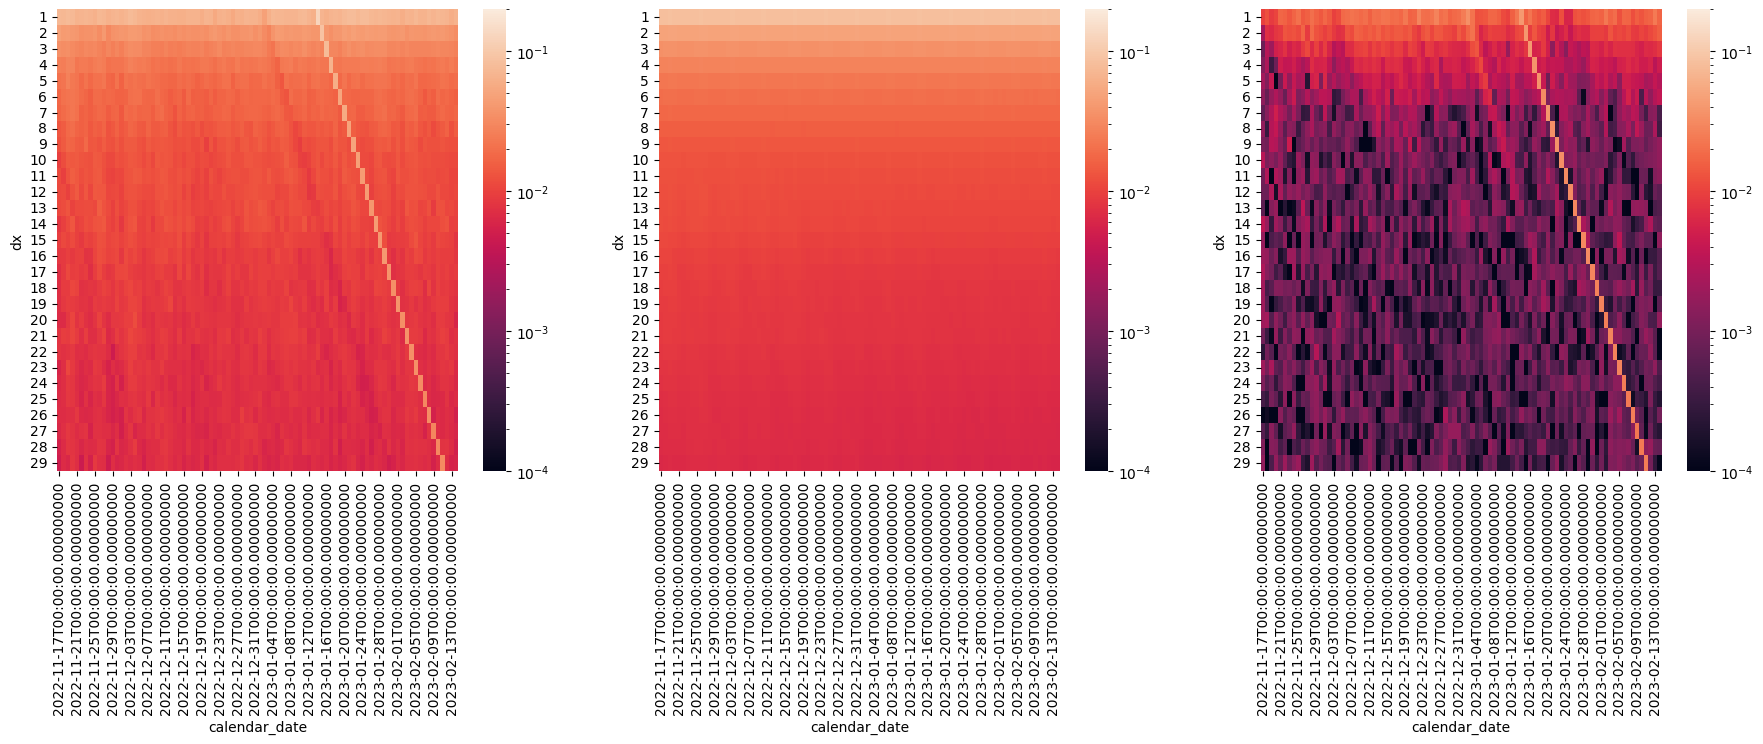

In [191]:
fig, axes = plt.subplots(1,3,figsize=(22,6))
lognorm = LogNorm(vmin=0.0001,vmax=0.2)

forecast_pivot_data = forecast_input.pivot(index='dx',columns='calendar_date',values='retention').copy()
predicted_pivot_data = pd.DataFrame(raw_predictions.prediction[:,:,4], index=forecast_pivot_data.index, columns=forecast_pivot_data.columns)
ape_error = abs(forecast_pivot_data - predicted_pivot_data)
sns.heatmap(forecast_pivot_data, norm=lognorm, ax=axes[0])
sns.heatmap(predicted_pivot_data, norm=lognorm, ax=axes[1])
lognorm2 = LogNorm(vmin=0.0001,vmax=0.2)
sns.heatmap(ape_error, vmax=0.01, norm=lognorm2, ax=axes[2])

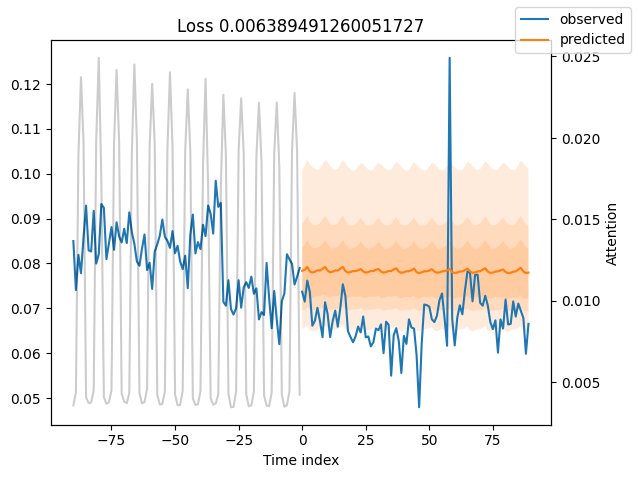

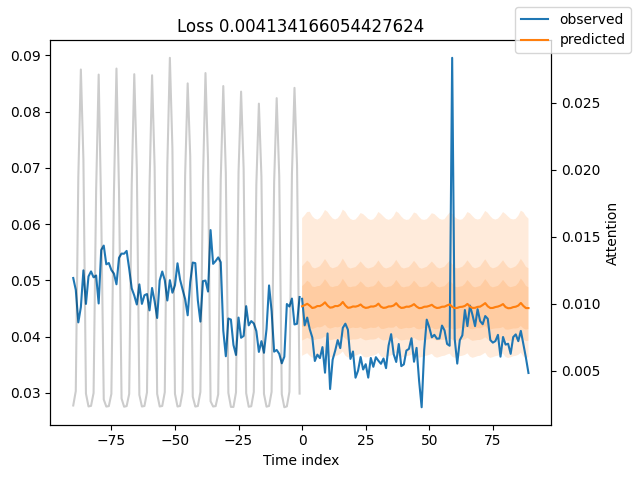

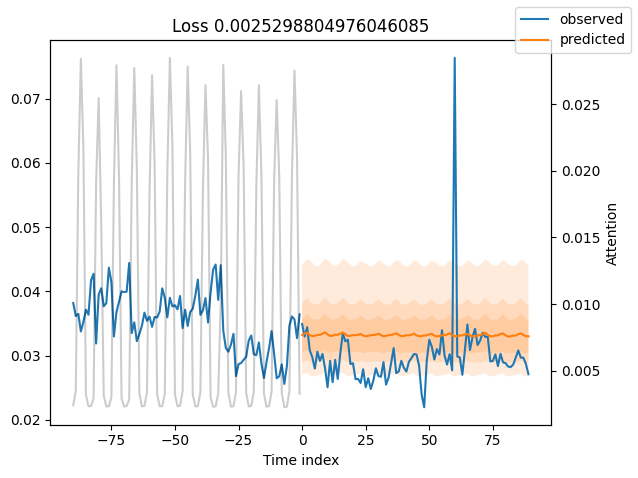

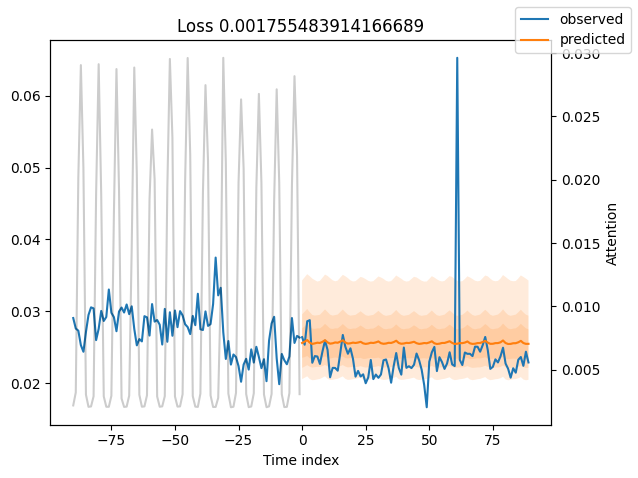

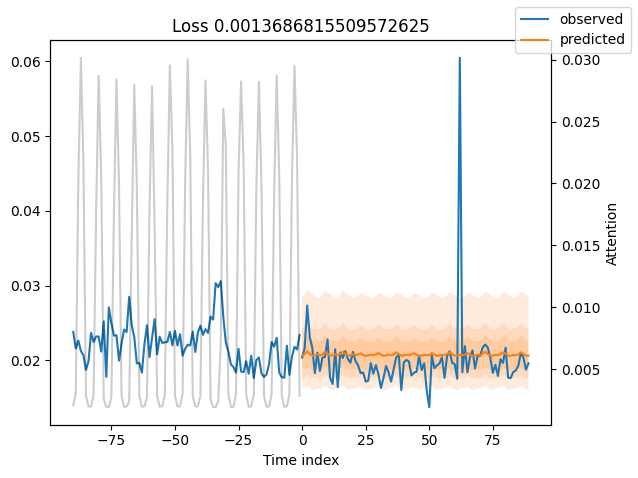

In [192]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [193]:
raw_predictions['prediction'].shape

torch.Size([29, 90, 7])

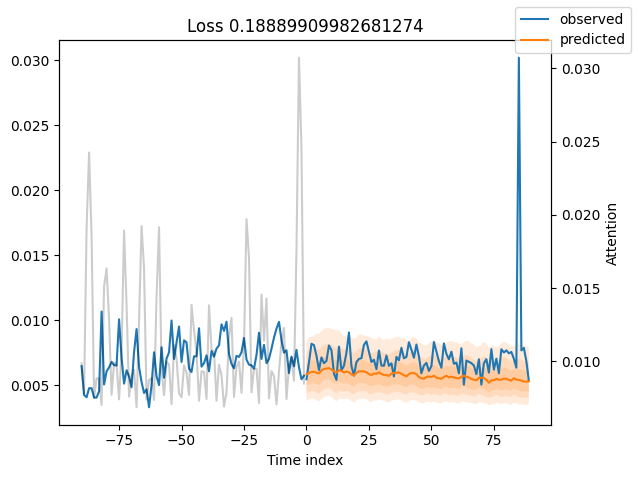

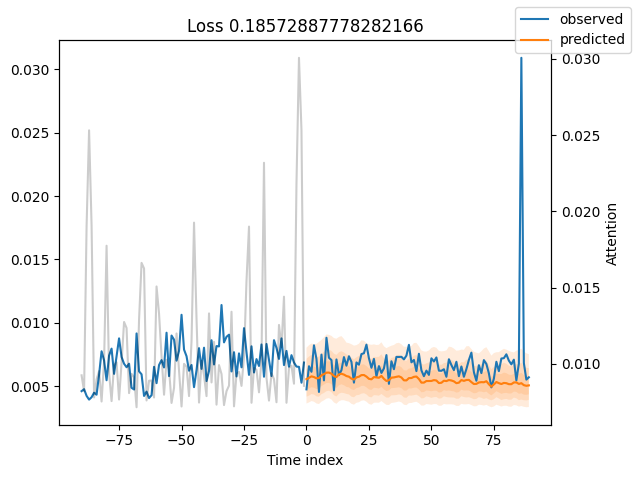

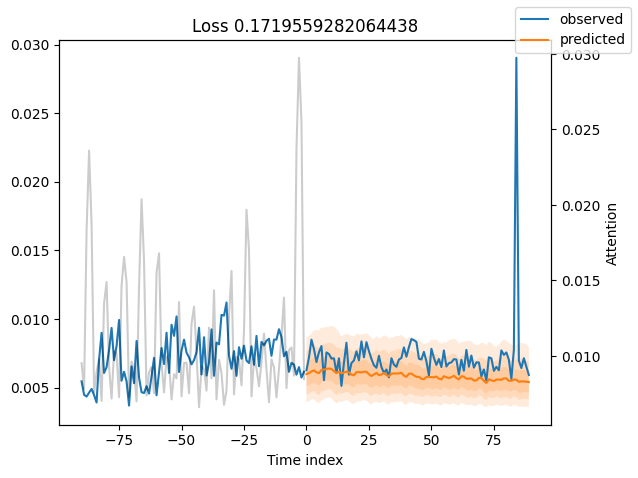

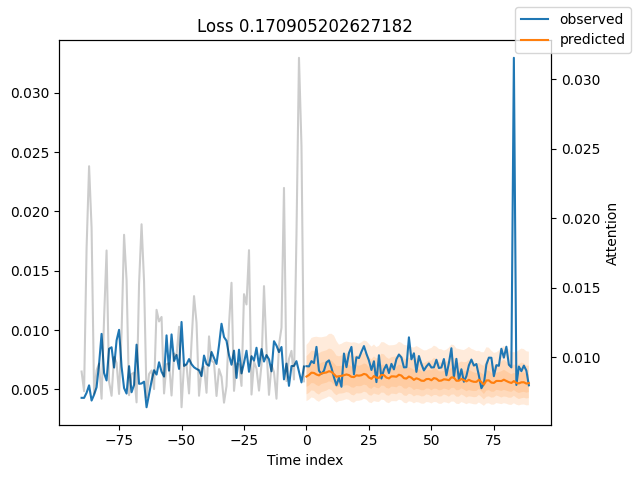

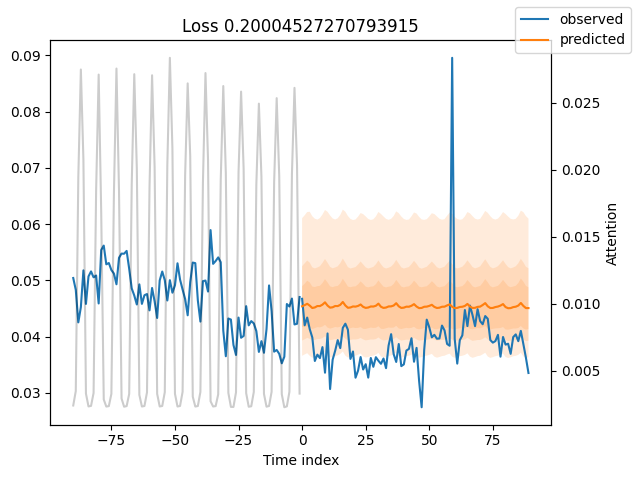

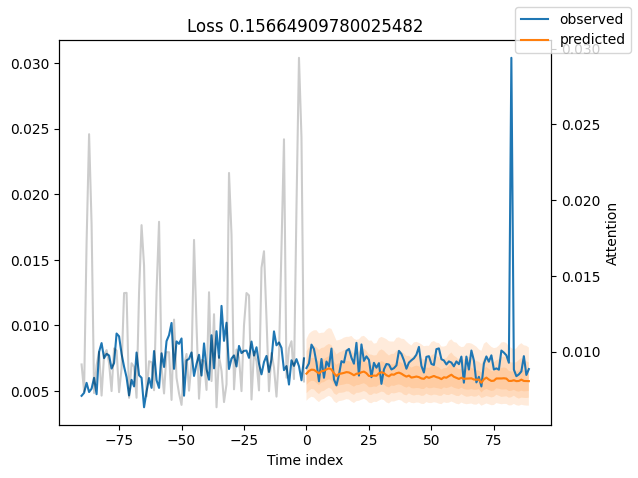

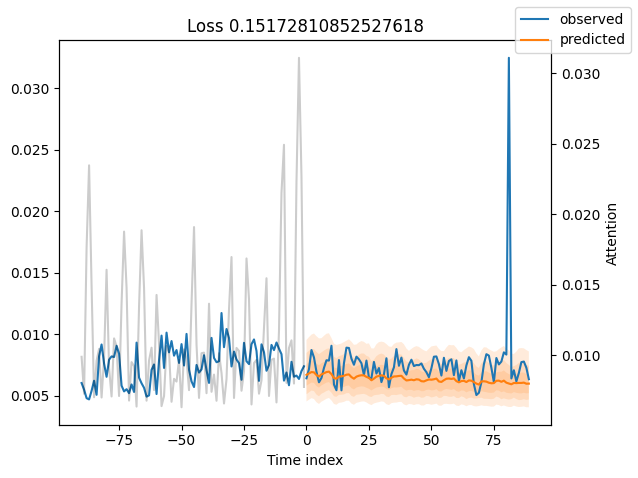

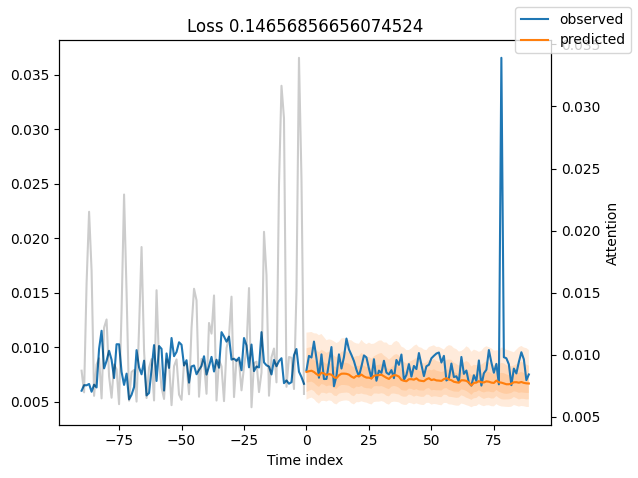

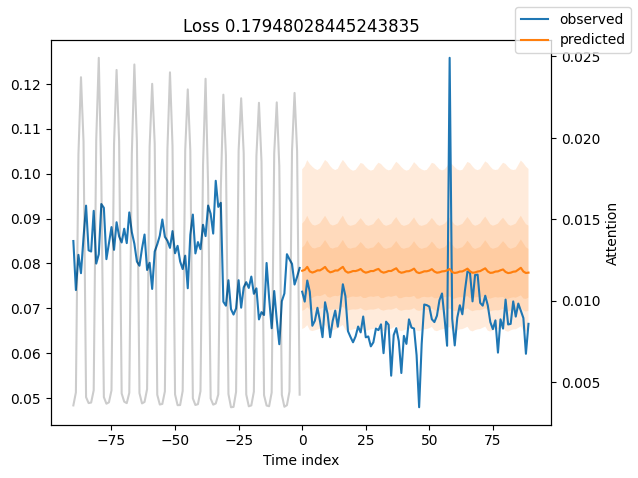

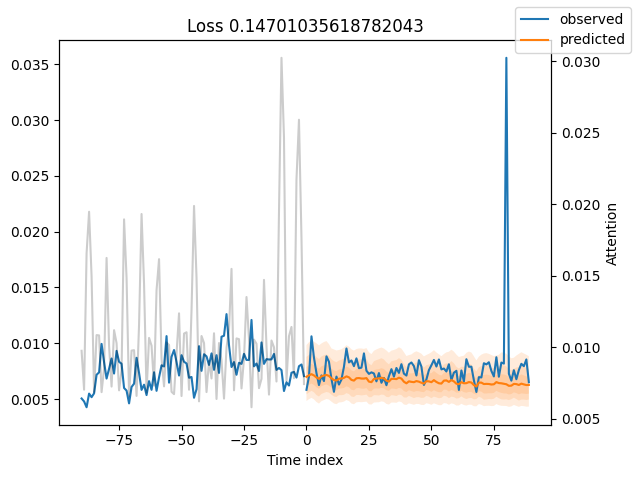

In [195]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

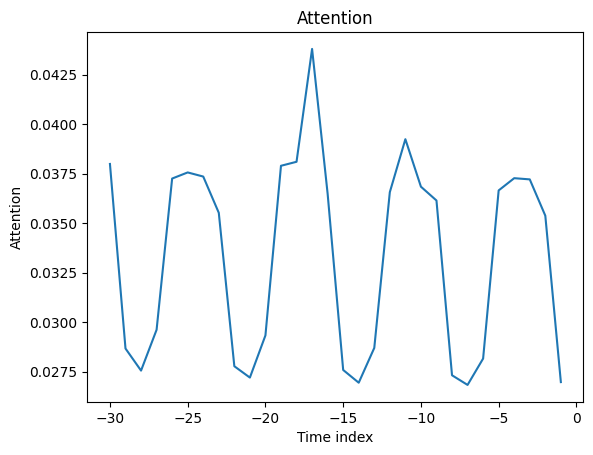

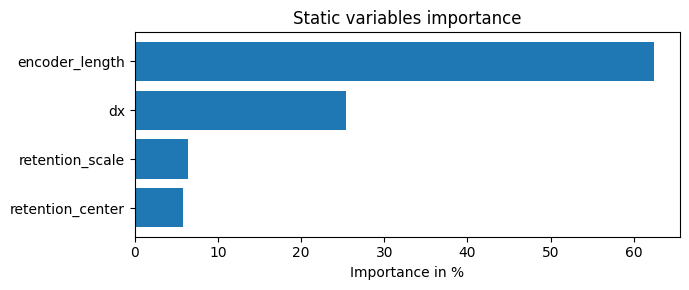

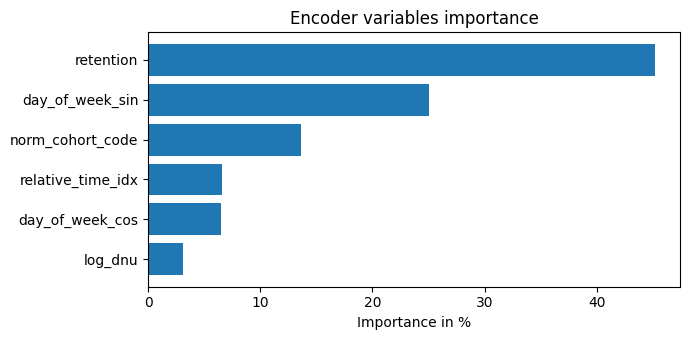

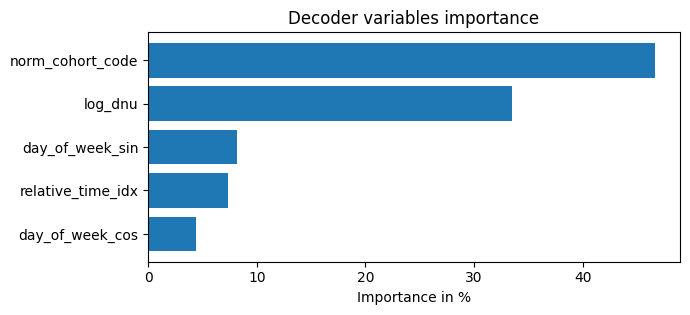

In [16]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)